<a href="https://colab.research.google.com/github/MikhailKuklin/time-series-analysis-forecasting/blob/main/notebooks/04_ts_deep_learning_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries

import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

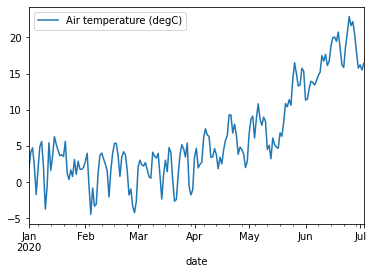

In [2]:
# download data

df = pd.read_csv('espoo_2020_2022.csv',
                 parse_dates= {"date" : ["Year","m","d"]})

df.dropna(axis=0,inplace=True)

df = df.groupby(['date']).mean()

df.index.freq = "D"

# non-stationary data

df = df.iloc[0:185]

df.plot();

In [3]:
len(df)

185

In [4]:
# split into train and test sets

train = df.iloc[:175]

test = df.iloc[175:]

In [5]:
len(test)

10

In [6]:
# scale 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [7]:
# generate TS 

from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 30
n_features =1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [8]:
# create LSTM model in keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [9]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


145/145 [==============================] - 3s 12ms/step - loss: 0.0379
Epoch 2/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0180
Epoch 3/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0132
Epoch 4/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0130
Epoch 5/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0142
Epoch 6/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0119
Epoch 7/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0116
Epoch 8/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0109
Epoch 9/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0118
Epoch 10/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0107
Epoch 11/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0103
Epoch 12/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0114
Epoch 13/50
145/145 [===

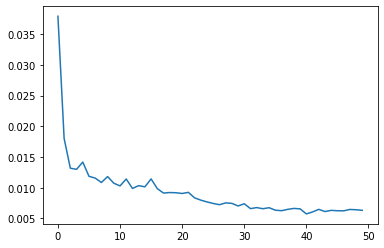

In [10]:
# plot errors

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [11]:
# evaluation

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

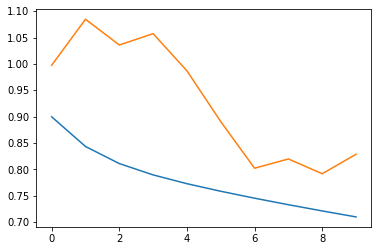

In [12]:
plt.plot(test_predictions)
plt.plot(scaled_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


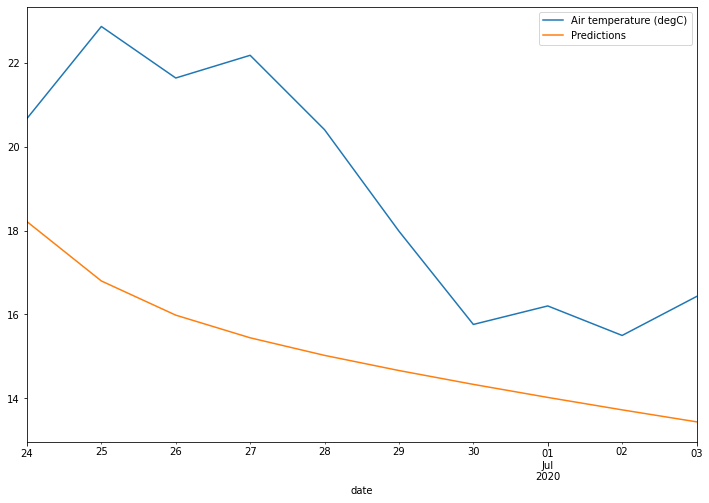

In [13]:
# inverse transformation and compare

true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

test.plot(figsize=(12,8))

In [14]:
# svae and load model

model.save('rnn_forecast.h5')

from keras.models import load_model
model_forecast = load_model('rnn_forecast.h5')

model_forecast.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
